In [1]:
# Importing the libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
# Creating objects to detect the face
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')

In [128]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
def img_augment(img):
    img_aug = []
    datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=45, 
                                 brightness_range=[0.5,1.5], zoom_range=[0.5,1.0])
    data = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # prepare iterator
    it = datagen.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(5):
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        img_aug.append(image)
    img_aug.append(img)
    return img_aug


### Reading and preprocessing images

In [3]:
def detect_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find faces in image using classifier
    faces = face_cascade.detectMultiScale(gray, 1.5, 5)
    
    # For every face found 
    if len(faces)==0:
        return (0,img)
    for (x,y,w,h) in faces:
        face_img = img[y:y + h, x:x + w]
    return (1,face_img)


In [136]:
images = np.load('C:\\Users\\rajpu\\Desktop\\dataset\\image_data.npy')
labels = np.load('C:\\Users\\rajpu\\Desktop\\dataset\\label_data.npy')

0

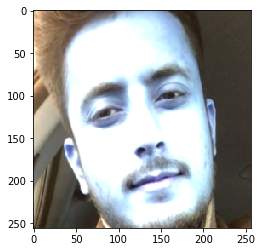

In [137]:
plt.imshow(i[48])
l[48]

In [7]:
# Shuffling the dataset
import random
# defining a random value for shuffle
def myfunction():
    return 0.5

random.shuffle(images, myfunction)
random.shuffle(labels, myfunction)


In [8]:
# Reshaping images

n=len(images)

data_images = np.zeros((n,256,256,3),dtype=np.float32)
data_labels = np.zeros((n),dtype=np.float32)

i = 0
for item in range(len(images)):
    data_images[i,:,:,:] = images[item]/255
    data_labels[i] = labels[item]
    i = i+1

0.0


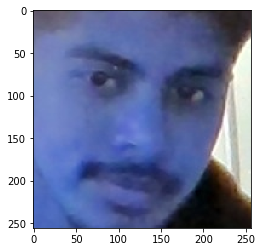

In [9]:
plt.imshow(data_images[20])
print(data_labels[10])

In [10]:
# Splitting the dataset into training and testing

from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(data_images, data_labels, test_size=0.2, random_state=42)


## Creating Model

In [11]:

import tensorflow as tf

from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.utils import to_categorical

Using TensorFlow backend.


In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 460800)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.fit(X_train, y_train, batch_size=5, epochs=5, validation_split=0.23)

Epoch 1/5
20/20 [==============================] - 8s 266ms/step - loss: 4.2687 - accuracy: 0.3911 - val_loss: 1.1891 - val_accuracy: 0.6552
Epoch 2/5
20/20 [==============================] - 5s 237ms/step - loss: 1.1227 - accuracy: 0.5685 - val_loss: 0.7518 - val_accuracy: 0.7241
Epoch 3/5
20/20 [==============================] - 5s 242ms/step - loss: 0.4426 - accuracy: 0.8464 - val_loss: 0.4050 - val_accuracy: 0.8966
Epoch 4/5
20/20 [==============================] - 5s 242ms/step - loss: 0.1014 - accuracy: 0.9980 - val_loss: 0.2010 - val_accuracy: 0.9310
Epoch 5/5
20/20 [==============================] - 5s 241ms/step - loss: 0.0448 - accuracy: 0.9990 - val_loss: 0.4738 - val_accuracy: 0.8621


In [15]:
y_pred = model.predict(X_test, batch_size = 5 )
y_pred = list(y_pred)

In [16]:
y_output = []
for i in range(len(y_pred)):
    max_val = max(y_pred[i])
    max_val_ind = list(y_pred[i]).index(max_val)
    y_output.append(max_val_ind)


## Predicting the faces in live video feed

In [84]:
# reading video and detecting people in it
cap = cv2.VideoCapture(0)
results = {0:'Abhi', 1:'Meet', 2:'Paras', 3:'Prashant', 4:'Sahil'}
online = {}
offline = {}

fa_img = np.zeros((n,256,256,3),dtype=np.float32)
i = 0
while True:
    
    #read each frame of the video and convert it to gray
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find faces in image using classifier
    faces = face_cascade.detectMultiScale(gray, 1.1, 10)
    
    # Draw rectangle around the faces
    on = []
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255,255), 2)  
        face_img = img[y:y + h, x:x + w]
        face_img =  cv2.resize(face_img, (256,256), interpolation = cv2.INTER_AREA)
        
        fa_img[0,:,:,:] = face_img/255
        
        y_pred = model.predict(fa_img)
        max_val = max(y_pred[0])
        max_val_ind = int(list(y_pred[0]).index(max_val))
        font = cv2.FONT_HERSHEY_TRIPLEX
        cv2.putText(img,results[max_val_ind],(x,y-2), font, 0.8, (0,255,255)) 
        on.append(results[max_val_ind])
    print(on)    
    off = check_offline(on, results)
    timestamp = get_timestamp()
    online = {timestamp:on}
    offline = {timestamp:off}
    print("Online: ", online)
    print("offline: ", offline)
    #display image
    cv2.imshow('img',img) 

    #if user pressed 'q' break
    if cv2.waitKey(1) == ord('q'): # 
        break;

cap.release() #turn off camera 
cv2.destroyAllWindows() #close all windows

['Paras']
Online:  {'2021/9/9 22:1': ['Paras']}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Prashant', 'Sahil']}
['Paras']
Online:  {'2021/9/9 22:1': ['Paras']}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Prashant', 'Sahil']}
['Meet']
Online:  {'2021/9/9 22:1': ['Meet']}
offline:  {'2021/9/9 22:1': ['Abhi', 'Paras', 'Prashant', 'Sahil']}
['Meet']
Online:  {'2021/9/9 22:1': ['Meet']}
offline:  {'2021/9/9 22:1': ['Abhi', 'Paras', 'Prashant', 'Sahil']}
['Meet']
Online:  {'2021/9/9 22:1': ['Meet']}
offline:  {'2021/9/9 22:1': ['Abhi', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant'

offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  {'2021/9/9 22:1': ['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']}
[]
Online:  {'2021/9/9 22:1': []}
offline:  

In [83]:

def check_offline(online, results):
    if online == []:
        return list(results.values())
    ret = []
    for item in results:
        if results[item] not in online:
            ret.append(results[item])
    return ret

In [57]:
from datetime import datetime
def get_timestamp():
    dateTimeObj = datetime.now()
    day = str(dateTimeObj.year)+ '/' + str(dateTimeObj.month) + '/' + str(dateTimeObj.day)
    time = str(dateTimeObj.hour) + ':' + str(dateTimeObj.minute) 
    return (day + ' '+ time)  

In [82]:
print(list(results.values()))

['Abhi', 'Meet', 'Paras', 'Prashant', 'Sahil']


In [131]:
s0,s1,s2,s3,s4 = 0,0,0,0,0
for i in labels:
    if i == 0:
        s0 = s0+1
    elif i == 1:
        s1 = s1+1
    elif i == 2:
        s2 = s2+1
    elif i == 3:
        s3 = s3+1
    else:
        s4 = s4+1

In [132]:
print(s0," ",s1," ", s2, " ", s3, " ", s4)

61   68   82   60   86
